# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [45]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [46]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [47]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-07 09:00:00+09:00,50524.308594,50642.789062,50158.468750,50167.449219,0,0.0,0.0
2025-11-07 09:15:00+09:00,50170.941406,50244.109375,50084.988281,50125.300781,0,0.0,0.0
2025-11-07 09:30:00+09:00,50119.210938,50250.269531,50096.929688,50246.261719,0,0.0,0.0
2025-11-07 09:45:00+09:00,50249.949219,50289.238281,50149.628906,50176.281250,0,0.0,0.0
2025-11-07 10:00:00+09:00,50166.171875,50166.171875,49855.601562,50006.718750,0,0.0,0.0
2025-11-07 10:15:00+09:00,50007.539062,50065.941406,49917.941406,49939.871094,0,0.0,0.0
2025-11-07 10:30:00+09:00,49949.429688,49981.648438,49770.550781,49876.738281,0,0.0,0.0
2025-11-07 10:45:00+09:00,49868.179688,49979.718750,49868.179688,49952.238281,0,0.0,0.0
2025-11-07 11:00:00+09:00,49953.960938,49974.730469,49826.550781,49869.320312,0,0.0,0.0


## 前日終値の取得

In [48]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-31 00:00:00+09:00    52411.339844
2025-11-04 00:00:00+09:00    51497.199219
2025-11-05 00:00:00+09:00    50212.269531
2025-11-06 00:00:00+09:00    50883.679688
2025-11-07 00:00:00+09:00    49853.589844
Name: Close, dtype: float64


Date
2025-11-06 00:00:00+09:00    50883.679688
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [49]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-359.37


## ローソク足チャート（小さいサイズ）

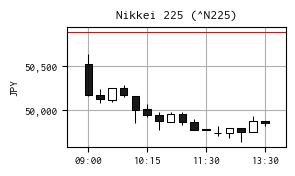

In [50]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [51]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [52]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-06 09:00:00+09:00,154.082001,154.139999,153.925003,153.940002,0,0.0,0.0
2025-11-06 09:15:00+09:00,153.944000,153.957993,153.850006,153.869995,0,0.0,0.0
2025-11-06 09:30:00+09:00,153.875000,153.973999,153.843994,153.960999,0,0.0,0.0
2025-11-06 09:45:00+09:00,153.960007,153.964996,153.869003,153.886993,0,0.0,0.0
2025-11-06 10:00:00+09:00,153.886993,153.889008,153.798004,153.863007,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-07 12:45:00+09:00,153.039993,153.082993,153.011993,153.056000,0,0.0,0.0
2025-11-07 13:00:00+09:00,153.054001,153.076996,153.009995,153.063995,0,0.0,0.0
2025-11-07 13:15:00+09:00,153.063995,153.182007,153.063995,153.125000,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [53]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-11-07 09:00:00+09:00,330.409957,331.184774,328.017502,328.076231
2025-11-07 09:15:00+09:00,327.861091,328.339235,327.299397,327.562835
2025-11-07 09:30:00+09:00,327.161709,328.017216,327.016264,327.991055
2025-11-07 09:45:00+09:00,328.045121,328.301610,327.390203,327.564197
2025-11-07 10:00:00+09:00,327.278109,327.278109,325.251985,326.237855
2025-11-07 10:15:00+09:00,326.451936,326.833190,325.867038,326.010196
2025-11-07 10:30:00+09:00,326.166262,326.376648,324.998196,325.691593
2025-11-07 10:45:00+09:00,325.667603,326.396017,325.667603,326.216554
2025-11-07 11:00:00+09:00,326.389807,326.525511,325.557333,325.836781


### 前日の終値のドル円レートから、前日の終値のドル換算

In [54]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-11-06 15:15:00+09:00


np.float64(153.8719940185547)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 330.68837517868377


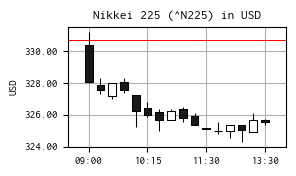

In [55]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()